# Deep Learning: Classification Problem
## Mohammad Ali Zamani
### Senior Machine Learning Scientist
 [zamani.ai](https://zamani.ai)


---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import torch
    import torch.utils.data
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
except:
    raise ImportError("For this example you need to install pytorch.")

try:
    import torchvision
    import torchvision.transforms as transforms
except:
    raise ImportError("For this example you need to install pytorch-vision.")
from torch.utils.data import Dataset, DataLoader
from typing import NamedTuple
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import copy
np.random.seed(100)

[[-6.33320822  1.21917722]
 [ 0.87920375 -4.55433942]
 [-3.74801231 -2.54355871]
 ...
 [-4.26678708  0.47914671]
 [-0.54267727 -2.26980056]
 [ 5.25318182 -3.50402644]]
[0. 0. 0. ... 1. 1. 1.]


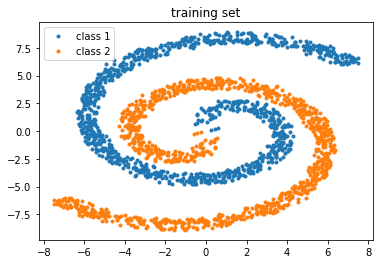

In [ ]:
def twospirals(n_points, difficulty, noise=1.):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * difficulty * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

difficulty = 500
X, y = twospirals(1000, difficulty)
print(X)
print(y)
plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [ ]:
class SprialDataSet(Dataset):
    """
    Loading the dataset
    """

    def __init__(self, n_points, difficulty):
        super(SprialDataSet, self).__init__()
        X, Y = twospirals(n_points, difficulty)
        self.set_len = len(X)
        X = torch.from_numpy(X)
        self.input = X.type(torch.float32)
        
        Y = torch.from_numpy(Y)
        Y = Y.unsqueeze(1)
        self.label = Y.type(torch.float32)
    
    def __len__(self):
        return self.set_len

    def __getitem__(self, idx):
        return self.input[idx], self.label[idx]

In [ ]:
class MLP(nn.Module):
    def __init__(self, args):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(2, args.fc1)
        self.fc2 = nn.Linear(args.fc1, args.fc2)
        self.fc_out =  nn.Linear(args.fc2, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc_out(x)
        return out

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class Optimization():
    def __init__(self, args, loss,  train_loader, val_loader, test_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        device = args.device

        self.model = MLP(args).to(device)
        
        print("number of trainable parameter = ", count_parameters(self.model))
        
        if args.optimizer == 'Adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=args.rate)
        elif args.optimizer == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=args.rate, momentum=args.sgd_momentum)

        self.scheduler = StepLR(self.optimizer, step_size=args.lr_decay_step)

        self.loss = loss
        self.device = device
        


    def train(self):
        total = 0.0
        total_loss = 0.0
        self.model.train()
        for iter, data in enumerate(self.train_loader):
            
            inputs, labels = data 

            inputs = inputs.to(self.device)
            self.model.zero_grad()
            outputs = self.model(inputs)
            labels = labels.to(self.device)
            loss = self.loss(outputs, labels)

            loss.backward()
            clipping_value = 1  # preventing exploding gradient signal
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), clipping_value)
            self.optimizer.step()

            total += 1
            total_loss += loss.item()
            loss_val = total_loss / total

        return loss_val

    def val_eval(self):
        total = 0.0
        total_loss = 0.0
        self.model.eval()
        for iter, data in enumerate(self.val_loader):
            inputs, labels = data
            inputs = inputs.to(self.device)

            # for evaluating the network, we disable the gradient calculation with the no_grad function
            with torch.no_grad():
                outputs = self.model(inputs)
                labels = labels.to(self.device)
                loss = self.loss(outputs, labels)

            total += 1
            total_loss += loss.item()
            loss_val = total_loss / total

        return loss_val

    def test_eval(self, graph=False):
        total = 0.0
        total_loss = 0.0
        self.model.eval()

        for iter, data in enumerate(self.test_loader):
            inputs, labels = data
            inputs = inputs.to(self.device)
           
            # for evaluating the network, we disable the gradient calculation with the no_grad function
            with torch.no_grad():
                outputs = self.model(inputs)
                labels = labels.to(self.device)
                loss = torch.mean((torch.sign(labels - 0.5) * torch.sign(outputs) > 0).type(torch.float32).to(self.device))

            total += 1
            total_loss += loss
            
           
        loss_val = total_loss / total
        return loss_val

In [ ]:
def main(args, train_loader, val_loader, test_loader):
    device = torch.device(args.device)
    best_val_error = np.inf

    if args.loss == 'BCE':
        loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    elif args.loss == 'CE':
        loss_function = nn.L1Loss(reduction='mean')
        nn.CrossEntropyLoss

    metric = Optimization(args, loss_function, train_loader, val_loader, test_loader)

    train_loss_records = []
    val_loss_records = []
    test_loss_records = []

    print("loading training, val and test set completed!")
    mistake_counter = 0  # mistakes counter for validation loss

    for epoch in range(args.epochs):
        train_loss = metric.train()
        train_loss_records.append(train_loss)
        metric.scheduler.step()

        val_loss = metric.val_eval()
        val_loss_records.append(val_loss)

        test_loss = metric.test_eval()
        test_loss_records.append(test_loss)

        if epoch > 1:
            if val_loss_records[-1] > val_loss_records[-2]:
                mistake_counter += 1

        if val_loss < best_val_error:
            best_results = {
                'epoch': epoch + 1,
                'state_dict': copy.deepcopy(metric.model.state_dict()),
                'model': metric.model,
                'best_val_error': val_loss,
                'best_test_error': test_loss,
                'optimizer': copy.deepcopy(metric.optimizer.state_dict()),
                'args': args
            }
            best_val_error = val_loss
        print(
            '[Epoch: %3d/%3d] LR: %0.8f  Train loss: %.4f,    Val loss: %.4f,   Test Acc: %.4f'
            % (epoch + 1, args.epochs, metric.scheduler.get_lr()[0], train_loss_records[epoch], val_loss_records[epoch],
               test_loss_records[epoch]))
        
        if mistake_counter >= args.tol or epoch == args.epochs - 1:
            print('Training is terminated: validation loss has increased')
            break
    return test_loss, val_loss

In [ ]:
class Args(NamedTuple):
    rate: float  # learning rate
    lr_decay_step: int  # learning rate decay
    batch_size: int  # minibatch size
    epochs: int  # maximum training epochs
    sample_num: int  # number of sample to be loaded
    tol: int  # tolerance for the validation error increment
    device: str  # cuda or cpu

    loss: str  # loss function     
    optimizer: str # optimizer method
    sgd_momentum: float #

    dropout: float  # the probability for dropout 
    fc1: int # 1st hidden layer's units
    fc2: int # add more layers if necessary

In [ ]:
args = Args(
            rate=0.1,
            lr_decay_step=5,
            batch_size=32,
            epochs=200,
            sample_num=1000,
            tol=5,
            loss='BCE',
            device='cuda',

            optimizer='Adam',
            sgd_momentum=0.1,
            dropout=0.2,
            fc1=16, # change the first layer units 
            fc2=8 #  adjust number of next hidden unit after addition
            )

difficulty = 500
training_set = SprialDataSet(1024, difficulty)
val_set = SprialDataSet(64, difficulty)
test_set = SprialDataSet(128, difficulty)
train_loader = DataLoader(training_set, batch_size=args.batch_size, num_workers=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=args.batch_size, num_workers=8, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=8, shuffle=False, drop_last=True)

main(args, train_loader, val_loader, test_loader)

number of trainable parameter =  193
loading training, val and test set completed!


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch:   1/200] LR: 0.10000000  Train loss: 0.5068,    Val loss: 0.3408,   Test Acc: 0.8008


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[Epoch:   2/200] LR: 0.10000000  Train loss: 0.3241,    Val loss: 0.1732,   Test Acc: 0.9219
[Epoch:   3/200] LR: 0.10000000  Train loss: 0.2161,    Val loss: 0.2434,   Test Acc: 0.9062
[Epoch:   4/200] LR: 0.10000000  Train loss: 0.1895,    Val loss: 0.1489,   Test Acc: 0.9570
[Epoch:   5/200] LR: 0.00100000  Train loss: 0.2063,    Val loss: 0.1297,   Test Acc: 0.9570
[Epoch:   6/200] LR: 0.01000000  Train loss: 0.0951,    Val loss: 0.0576,   Test Acc: 0.9805
[Epoch:   7/200] LR: 0.01000000  Train loss: 0.0778,    Val loss: 0.0481,   Test Acc: 0.9805
[Epoch:   8/200] LR: 0.01000000  Train loss: 0.0685,    Val loss: 0.0362,   Test Acc: 0.9883
[Epoch:   9/200] LR: 0.01000000  Train loss: 0.0561,    Val loss: 0.0356,   Test Acc: 0.9961
[Epoch:  10/200] LR: 0.00010000  Train loss: 0.0471,    Val loss: 0.0349,   Test Acc: 0.9922
[Epoch:  11/200] LR: 0.00100000  Train loss: 0.0417,    Val loss: 0.0370,   Test Acc: 0.9922
[Epoch:  12/200] LR: 0.00100000  Train loss: 0.0408,    Val loss: 0.03

(tensor(0.9922, device='cuda:0'), 0.033126819878816605)